# NAVER TRENDS CRAWLING

* 공식 API 제공 (ID/SECRET 발급)
* 각 영화마다 키워드 설정하여 트랜드 조회 가능
* 기간별, 성별, 연령별, 채널별 조회 가능
* 동시 조회 가능 검색어 5개

[Reference](https://brunch.co.kr/@sukhyun9673/13)

#### DEFINE FUNCTIONS

In [5]:
class NaverTrend:    
    def __init__(self, api_info, movie_data_full):
        """
        NaverTrend Class
        """
        self.client_id = api_info["client_id"]
        self.client_secret = api_info["client_secret"]
        self.url = api_info["url"]
        self.movie_data_full = movie_data_full
        self.min_movie = None
        self.max_movie = None

    def define_body(self, movie_list):
        """
        TREND 조회 요청에 필요한 Body 파트를 정의한다.
        """
        keywords_list = ["{\"groupName\": \"" + movie + "\", \"keywords\": [\"" + movie + "\"]}"  for movie in movie_list]
        body ="{\"startDate\":\"2018-12-01\", \"endDate\":\"2019-12-30\", \"timeUnit\":\"date\", \"keywordGroups\":" + "[" + ", ".join(keywords_list) + "]}"
        return(body)

    def get_response_body(self, body):
        """
        Naver API로부터 트렌드 조회 결과를 받아온다.
        """
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id", self.client_id)
        request.add_header("X-Naver-Client-Secret", self.client_secret)
        request.add_header("Content-Type", "application/json")
        response = urllib.request.urlopen(request, data = body.encode("utf-8"))
        rescode = response.getcode()
        if(rescode==200):
            response_body_str = response.read().decode("utf-8") # repsonse body string
            response_body_dict = json.loads(response_body_str) # response body dict
            return(response_body_dict)
        else:
            print("Error Code:" + rescode)
    
    def response_to_df(self, response_dict): # OLD NAME: get_trends
        """
        response_body_dict를 DataFrame으로 변환한다.
        """
        response = pd.DataFrame()
        for i in range(len(response_dict["results"])): # Need to find for loop alternatives.
            ttl = response_dict["results"][i]["title"]
            data = response_dict["results"][i]["data"]
            
            time = np.array([datetime.strptime(i["period"], "%Y-%m-%d") for i in data])
            value = np.array([j["ratio"] for j in data])
            title = np.repeat(ttl, len(value), axis=0)
            
            trend = pd.DataFrame({"Keyword": title, "Time": time, "Trend_index": value})
            response = pd.concat([response, trend])
        response = response.reset_index().drop(["index"], axis=1)
        return(response)
    
    def recursive_min_max_search(self, init_cand):
        """
        전체 리스트 중 검색 횟수가 최대, 최소인 영화를 찾을 때까지 5개씩 TREND를 요청한다.
        """
        def min_max_search(cand):
            n_movie = len(cand)
            rng = range(1, n_movie, 5)

            min_cand_subset, max_cand_subset = [], []
            for i, idx in zip(rng, range(len(rng))):
                movie_subset = [row["title"] for idx, row in cand.iloc[i:i+5].iterrows()]
                body = self.define_body(movie_subset)
                response_dict_subset = self.get_response_body(body)
                response_subset = self.response_to_df(response_dict_subset)
                
                min_in_five = response_subset.iloc[response_subset['Trend_index'].idxmin()]["Keyword"]
                max_in_five = response_subset.iloc[response_subset['Trend_index'].idxmax()]["Keyword"]
                min_cand_subset.append(min_in_five)
                max_cand_subset.append(max_in_five)
                print(min_in_five, "|", max_in_five)
            return(min_cand_subset, max_cand_subset)

        min_cand, max_cand = min_max_search(init_cand)
        if len(min_cand) != 1 or len(max_cand) != 1:
            print("================================================")
            return(self.recursive_min_max_search(init_cand[init_cand.title.isin(set([*min_cand, *max_cand]))]))
        else:
            return(min_cand, max_cand)

    def set_min_max_movie(self, min_max_movie = None):
        if min_max_movie == None:
            self.min_movie, self.max_movie = self.recursive_min_max_search(self.movie_data_full)
        else:
            self.min_movie, self.max_movie = [min_max_movie[0]], [min_max_movie[1]]
        return
    
    def get_trend_with_minmax(self, target):
        """
        MIN, MAX와 함께 특정 영화의 TREND를 조회한다.
        """
        body = self.define_body(set([*target, *self.min_movie, *self.max_movie]))
        response_dict_subset = self.get_response_body(body)
        response_subset = self.response_to_df(response_dict_subset)
        target_trend = response_subset[response_subset.Keyword.isin(target)]
        return(target_trend)

In [ ]:
def get_response_body(body):
    """
    """
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    rescode = response.getcode()
    if(rescode==200):
        response_body_str = response.read().decode("utf-8") # repsonse body string
        response_body = json.loads(response_body_str) # response body dict
        return(response_body)
    else:
        print("Error Code:" + rescode)

In [ ]:
def get_trends(result):
    out = pd.DataFrame()
    for i in range(len(result["results"])):
        ttl = result["results"][i]["title"]
        data = result["results"][i]["data"]
        time = np.array([datetime.strptime(i["period"], "%Y-%m-%d") for i in data])
        value = np.array([j["ratio"] for j in data])
        title = np.repeat(ttl, len(value), axis=0)
        trend = pd.DataFrame({"Keyword": title, "Time": time, "Trend_index": value})
    return(out.reset_index())

In [ ]:
def recursive_min_max_search(init_data):
    def min_max_search(dat):
        n_movie = len(dat)
        rng = range(1, n_movie, 5)

        max_cand_out, min_cand_out = [] ,[]
        for i, idx in zip(rng, range(len(rng))):
            movie_subset = ["{\"groupName\": \"" + row["title"] + "\", \"keywords\": [\"" + row["title"] + "\"]}"  for idx, row in dat.iloc[i:i+5].iterrows()]
            body = """
            {\"startDate\":\"2018-12-01\", 
            \"endDate\":\"2019-12-30\",
            \"timeUnit\":\"date\",
            \"keywordGroups\":
            """ + "[" + ", ".join(movie_subset) + "]}"
            response_body = get_response_body(body)
            result = json.loads(response_body)
            trends_subset = get_trends(result)
            max, min = trends_subset.iloc[trends_subset['Trend_index'].idxmax()]["Keyword"], trends_subset.iloc[trends_subset['Trend_index'].idxmin()]["Keyword"]
            max_cand_out.append(max)
            min_cand_out.append(min)
            print(max, "|", min)
        return(max_cand_out, min_cand_out)

    x, y = min_max_search(init_data)
    if len(x) != 1 or len(y) != 1:
        print("================================================")
        return(recursive_min_max_search(init_data[init_data.title.isin(set([*x, *y]))]))
    else:
        return(x, y)

In [ ]:
def get_trend_with_minmax(target_movie, min_movie, max_movie):
    movie_subset = ["{\"groupName\": \"" + movie_nm + "\", \"keywords\": [\"" + movie_nm + "\"]}" for movie_nm in set([target_movie, *min_movie, *max_movie])]
    body = """
    {\"startDate\":\"2018-12-01\", 
    \"endDate\":\"2019-12-30\",
    \"timeUnit\":\"date\",
    \"keywordGroups\":
    """ + "[" + ", ".join(movie_subset) + "]}"
    response_body = get_response_body(body)
    result = json.loads(response_body)
    trends_subset = get_trends(result)
    out = trends_subset[trends_subset.Keyword == target_movie]
    return(out)

---

#### EXEUCTION

In [ ]:
client_id = "6GPEYsepjIil0OCSMnU5"
client_secret = "QUd5qt5QU9"
url = "https://openapi.naver.com/v1/datalab/search";

In [ ]:
client_id = "fe5kOiBVrMopPhGmaeeh"
client_secret = "zauzLV_BPn"
url = "https://openapi.naver.com/v1/datalab/search";

In [ ]:
movie_list = pd.read_table("~/crawling/data/movie2019.dat",
                           sep = "|",
                           header=None,
                           names = ["title", "year", "month", "day"])

open_date = movie_list.year.str.replace("년", "") + "-" + movie_list.month.str.replace("월", "").str.zfill(2) + "-" +movie_list.day.str.replace("일", "").str.zfill(2)
movie_list["open_date"] = [datetime.strptime(i, "%Y-%m-%d") for i in open_date]
movie_list = movie_list.drop(['year', 'month', 'day'], axis=1)

In [ ]:
min_movie, max_movie = recursive_min_max_search(movie_list)

In [ ]:
result_list = [get_trend_with_minmax(target_movie, min_movie, max_movie) for target_movie in [*movie_list.title]]

result_full = pd.concat(result_list).drop("index", axis=1)

result_merged = result_full.merge(movie_list, how="left", left_on="Keyword", right_on="title").drop("title", 1)

result_merged["d_date"] = result_merged.Time - result_merged.open_date

result_merged

result_final.to_csv("~/crawling/data/result_final.csv")

---

#### EXECUTION 2

#### IMPORT PACKAGE

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import urllib.request
import json

In [2]:
api_info = {
    "client_id": "fe5kOiBVrMopPhGmaeeh",
    "client_secret": "zauzLV_BPn",
    "url": "https://openapi.naver.com/v1/datalab/search"
}

In [3]:
movie_list = pd.read_table("~/crawling/data/movie2019.dat",
                           sep = "|",
                           header=None,
                           names = ["title", "year", "month", "day"])

open_date = movie_list.year.str.replace("년", "") + "-" + movie_list.month.str.replace("월", "").str.zfill(2) + "-" +movie_list.day.str.replace("일", "").str.zfill(2)
movie_list["open_date"] = [datetime.strptime(i, "%Y-%m-%d") for i in open_date]
movie_list = movie_list.drop(['year', 'month', 'day'], axis=1)

In [6]:
NT = NaverTrend(api_info, movie_list)

In [7]:
NT.set_min_max_movie(["감쪽같은 그녀", "백두산"])

In [10]:
result = NT.get_trend_with_minmax(["백두산", "말모이", "시동"])

In [47]:
result_list = [NT.get_trend_with_minmax([target_movie]) for target_movie in [*movie_list.title]]

In [52]:
result_full = pd.concat(result_list)

In [58]:
result_merged = result_full.merge(NT.movie_data_full, how="left", left_on="Keyword", right_on="title").drop("title", 1)

In [59]:
result_merged["d_date"] = result_merged.Time - result_merged.open_date

In [60]:
result_merged

,Keyword,Time,Trend_index,open_date,d_date
0,언니,2018-12-01,0.10144,2019-01-01,-31 days
1,언니,2018-12-02,0.08461,2019-01-01,-30 days
2,언니,2018-12-03,2.77561,2019-01-01,-29 days
3,언니,2018-12-04,0.20092,2019-01-01,-28 days
4,언니,2018-12-05,0.17483,2019-01-01,-27 days
...,...,...,...,...,...
39125,천문: 하늘에 묻는다,2019-12-26,0.72234,2019-12-26,0 days
39126,천문: 하늘에 묻는다,2019-12-27,4.44656,2019-12-26,1 days
39127,천문: 하늘에 묻는다,2019-12-28,4.09427,2019-12-26,2 days
39128,천문: 하늘에 묻는다,2019-12-29,4.27360,2019-12-26,3 days


In [11]:
result_final.to_csv("~/crawling/data/result_final.csv")

,Keyword,Time,Trend_index
0,말모이,2018-12-01,0.21419
1,말모이,2018-12-02,0.13052
2,말모이,2018-12-03,7.50304
3,말모이,2018-12-04,0.56518
4,말모이,2018-12-05,0.20541
...,...,...,...
1180,시동,2019-12-26,11.97438
1181,시동,2019-12-27,9.13772
1182,시동,2019-12-28,11.13778
1183,시동,2019-12-29,10.60981


---

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

No handles with labels found to put in legend.


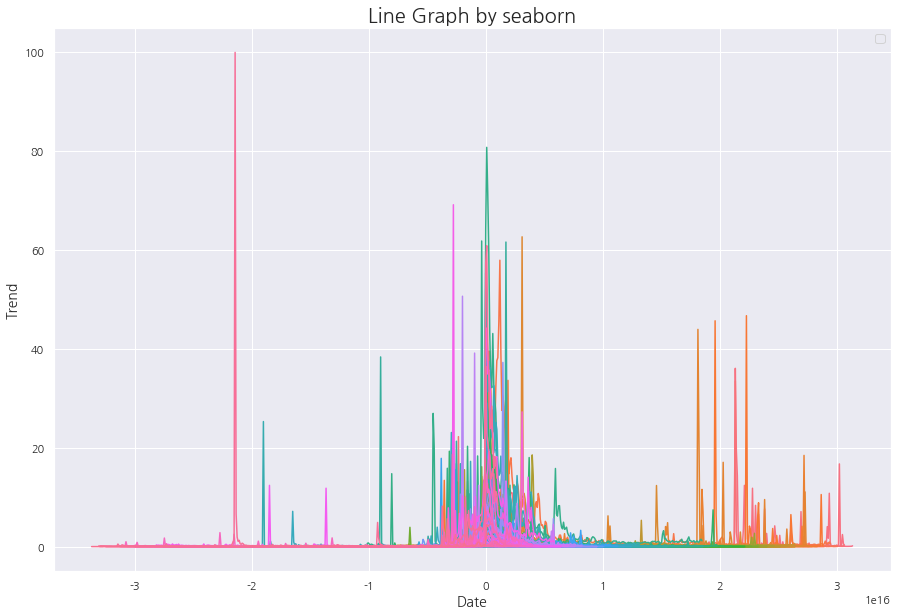

In [63]:
mpl.rc('font', family='NanumGothic')
mpl.rc('figure', figsize=(15,10))
mpl.rc('axes', unicode_minus=False)

# ax = sns.lineplot(x='Time', y='Trend_index', hue='Keyword', data=result)
ax = sns.lineplot(x='d_date', y='Trend_index', hue='Keyword', data=result_merged, legend=False)

plt.title('Line Graph by seaborn', fontsize=20)
plt.ylabel('Trend', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.show()

---

### 한글 폰트 문제 해결

In [17]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_list

['/usr/share/fonts/truetype/nanum/NanumSquareL.ttf',
 '/usr/share/fonts/opentype/urw-base35/P052-Roman.otf',
 '/usr/share/texmf/fonts/opentype/public/lm/lmsansdemicond10-oblique.otf',
 '/usr/share/texmf/fonts/opentype/public/lm/lmmono9-regular.otf',
 '/usr/share/fonts/opentype/urw-base35/NimbusSansNarrow-Regular.otf',
 '/usr/share/fonts/opentype/urw-base35/Z003-MediumItalic.otf',
 '/usr/share/texmf/fonts/opentype/public/lm/lmroman7-italic.otf',
 '/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf',
 '/usr/share/fonts/opentype/urw-base35/P052-Bold.otf',
 '/usr/share/fonts/opentype/urw-base35/NimbusSansNarrow-Oblique.otf',
 '/usr/share/fonts/truetype/lato/Lato-BoldItalic.ttf',
 '/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf',
 '/usr/share/texmf/fonts/opentype/public/tex-gyre-math/texgyrepagella-math.otf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/lato/Lato-Heavy.ttf',
 '/usr/share/texmf/fonts/opentype/public/tex-gyre/texgyreheroscn

In [26]:
for font in fm.fontManager.ttflist:
    if 'Nanum' in font.name:
        print(font.name, font.fname)

NanumSquare /usr/share/fonts/truetype/nanum/NanumSquareL.ttf
NanumMyeongjo /usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
NanumSquareRound /usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
NanumSquareRound /usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
NanumSquare /usr/share/fonts/truetype/nanum/NanumSquareR.ttf
NanumMyeongjo /usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
NanumBarunGothic /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
NanumGothicCoding /usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf
NanumBarunpen /usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf
NanumBarunGothic /usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf
NanumSquare /usr/share/fonts/truetype/nanum/NanumSquareB.ttf
NanumGothic /usr/share/fonts/truetype/nanum/NanumGothic.ttf
Nanum Brush Script /usr/share/fonts/truetype/nanum/NanumBrush.ttf
NanumSquare /usr/share/fonts/truetype/nanum/NanumSquareEB.ttf
NanumBarunpen /usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf

In [18]:
fm.FontProperties(fname=font_list[10]).get_name()

'Lato'

In [19]:
mpl.get_cachedir()

'/home/jupyter-tshahn2020/.cache/matplotlib'

In [ ]:
!rm '/home/jupyter-tshahn2020/.cache/matplotlib/fontlist-v310.json'

---

#### TEMPORARY CODE

In [ ]:
n_movie = len(movie_list)
for i in [*range(1, n_movie, 5)]:
    print(movie_list.iloc[i:i+5])
    print("==============================================")

In [ ]:
n_movie = len(movie_list)
for i in [*range(1, n_movie, 5)]:
    movie_subset = ["{\"groupName\": \"" + row["title"] + "\", \"keywords\": [\"" + row["title"] + "\"]}"  for idx, row in movie_list.iloc[i:i+5].iterrows()]

In [ ]:
print(j)

In [ ]:
client_id = "6GPEYsepjIil0OCSMnU5"
client_secret = "QUd5qt5QU9"
url = "https://openapi.naver.com/v1/datalab/search";

In [ ]:
response_body = get_response_body(body)
result = json.loads(response_body)
trends = get_trends(result)

In [ ]:
trends

In [ ]:
# OLD BODY
body ="""
{\"startDate\":\"2018-12-01\", 
\"endDate\":\"2019-12-30\",
\"timeUnit\":\"date\",
\"keywordGroups\":
""" + "[" + ", ".join(movie_subset) + "]," + """
\"device\":\"pc\",
\"ages\":[\"1\",\"2\"],
\"gender\":\"f\"}
""";

In [ ]:
client_id = "fe5kOiBVrMopPhGmaeeh"
client_secret = "zauzLV_BPn"
url = "https://openapi.naver.com/v1/datalab/search";

movie_list = pd.read_table("~/crawling/data/movie2019.dat",
                           sep = "|",
                           header=None,
                           names = ["title", "year", "month", "day"])

open_date = movie_list.year.str.replace("년", "") + "-" + movie_list.month.str.replace("월", "").str.zfill(2) + "-" +movie_list.day.str.replace("일", "").str.zfill(2)
movie_list["open_date"] = [datetime.strptime(i, "%Y-%m-%d") for i in open_date]
movie_list = movie_list.drop(['year', 'month', 'day'], axis=1)

i = 1
dat = movie_list

movie_subset = ["{\"groupName\": \"" + row["title"] + "\", \"keywords\": [\"" + row["title"] + "\"]}"  for idx, row in dat.iloc[i:i+5].iterrows()]
body = """
{\"startDate\":\"2018-12-01\", 
\"endDate\":\"2019-12-30\",
\"timeUnit\":\"date\",
\"keywordGroups\":
""" + "[" + ", ".join(movie_subset) + "]}"


request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id", client_id)
request.add_header("X-Naver-Client-Secret", client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    out = response.read().decode("utf-8")
else:
    print("Error Code:" + rescode)

---